In [ ]:
from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [ ]:
tweets_df = pd.read_csv('/mydrive/MyDrive/CMPE255/tweets.csv')
tweets_df.dropna(inplace=True)

In [ ]:
tweets_df.head()

,content,class
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets_df['content'] = tweets_df['content'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
tweets_df.head()

,content,class
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,upset can't update Facebook texting it... migh...,0
2,@Kenichan I dived many times ball. Managed sav...,0
3,whole body feels itchy like fire,0
4,"@nationwideclass no, behaving all. i'm mad. he...",0


In [ ]:
tweets_df.content.str.replace('[^a-zA-Z\s]', '')

0          switchfoot httptwitpiccomyzl  Awww thats bumme...
1          upset cant update Facebook texting it might cr...
2          Kenichan I dived many times ball Managed save ...
3                           whole body feels itchy like fire
4          nationwideclass no behaving all im mad here I ...
                                 ...                        
3188993    Atlanta Police searching man wanted rape https...
3188994    We REALLY fuckin listen  music submissions Sub...
3188995    Thank you Love travel readers Youre great fath...
3188996                He never calls back guess im annoying
3188997    So racism effectively proven emmyjewel go sit ...
Name: content, Length: 3188997, dtype: object

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(tweets_df['content'])
tweets_df['content'] = tokenizer.texts_to_sequences(tweets_df['content'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


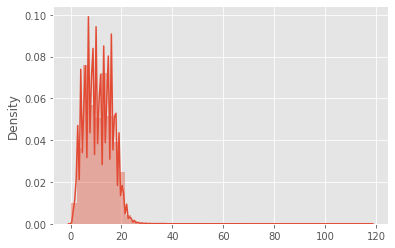

In [ ]:
X_lens = [len(x) for x in tweets_df['content'].values]
X_lens = np.array(X_lens)
sns.distplot(X_lens)

In [ ]:
mean_tweet_len = np.mean(X_lens)
std_tweets = np.std(X_lens)
print(mean_tweet_len, std_tweets)

11.059464151267624 5.164829828958415


In [ ]:
# uniform tweet length to use is mean + 2*std_dev = 11 + 10 = 21
MAX_LENGTH = 21
np.unique((X_lens>=MAX_LENGTH), return_counts=True)

(array([False,  True]), array([3104756,   84241]))

In [ ]:
(3104656/(3104756+84241))

0.9735524994222321

In [ ]:
labels = tweets_df.pop('class')

In [ ]:
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df, labels, test_size=0.2)
X_train_content = X_train.pop('content')
X_test_content = X_test.pop('content')


In [ ]:


X_train_content = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                             maxlen=MAX_LENGTH,
                                                             dtype='int32',
                                                             padding='post',
                                                             truncating='post')
X_test_content = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       maxlen=MAX_LENGTH,
                                                       dtype='int32',
                                                       padding='post',
                                                       truncating='post')

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
model = Sequential()
model.add(Embedding(7000, 32, input_length=MAX_LENGTH))
model.add(Conv1D(MAX_LENGTH, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 32)            224000    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 21)            2037      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 21)            0         
_________________________________________________________________
flatten (Flatten)            (None, 210)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               52750     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 279,038
Trainable params: 279,038
Non-trainable params: 0
__________________________________________________

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=5,
                                            mode='max',
                                          restore_best_weights=True)
history = model.fit([X_train_content, X_train],
                     y_train,
                     epochs=100,
                     batch_size=128,
                     validation_data=(
                           [X_test_content, X_test],
                            y_test
                     ),
callbacks=[callback])

Epoch 1/100
19932/19932 [==============================] - 116s 6ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/100
19932/19932 [==============================] - 116s 6ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 3/100
19932/19932 [==============================] - 115s 6ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 4/100
19932/19932 [==============================] - 117s 6ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 5/100
19932/19932 [==============================] - 116s 6ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 6/100
19932/19932 [==============================] - 117s 6ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 7/100
19932/19932 [==============================] - 118s 6ms/step - loss: 0.6932 - accuracy: 0.5012

In [ ]:
preds=model.predict([X_test_content, X_test])
model.evaluate([X_test_content, X_test], y_test)

19932/19932 [==============================] - 40s 2ms/step - loss: 0.6932 - accuracy: 0.5020


[0.6931861639022827, 0.5020382404327393]